### Learning the CDF function of table attribute values via Isotonic Regression

In [1]:
# auto reload all modules
%load_ext autoreload
%autoreload 2

from simple_cost_model import *
from tpch_qgen_class_v2 import *

import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from scipy.stats import zipf
import pickle

In [2]:
# Function to update the model incrementally
def update_model(cdf_model, new_point, new_cdf_value):
    # Append the new data point and its CDF value
    updated_data = np.append(cdf_model.X_thresholds_, new_point)
    updated_cdf_values = np.append(cdf_model.y_thresholds_, new_cdf_value)
    # Refit the model with the updated data
    cdf_model.fit(updated_data, updated_cdf_values)


# Function to predict CDF values, with handling for out-of-bounds
def predict_cdf_with_bounds(cdf_model, points):
    predictions = []
    min_data = min(cdf_model.X_thresholds_)
    max_data = max(cdf_model.X_thresholds_)
    
    for point in points:
        if point < min_data:
            predictions.append(0.0)  # CDF is 0 below the minimum
        elif point > max_data:
            predictions.append(1.0)  # CDF is 1 above the maximum
        else:
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)


def predict_cdf_with_extrapolation(cdf_model, points):
    predictions = []
    x_thresholds = cdf_model.X_thresholds_
    y_thresholds = cdf_model.y_thresholds_
    
    min_data = min(x_thresholds)
    max_data = max(x_thresholds)

    # Ensure there are enough points to calculate slopes
    if len(x_thresholds) > 1:
        # Calculate slopes for extrapolation
        left_slope = (y_thresholds[1] - y_thresholds[0]) / (x_thresholds[1] - x_thresholds[0])
        right_slope = (y_thresholds[-1] - y_thresholds[-2]) / (x_thresholds[-1] - x_thresholds[-2])
    else:
        # Default slopes if not enough points
        left_slope = 0
        right_slope = 0

    for point in points:
        if point < min_data:
            # Extrapolate linearly on the left
            extrapolated_value = y_thresholds[0] + left_slope * (point - min_data)
            predictions.append(max(0.0, extrapolated_value))  # Ensure CDF is not negative
        elif point > max_data:
            # Extrapolate linearly on the right
            extrapolated_value = y_thresholds[-1] + right_slope * (point - max_data)
            predictions.append(min(1.0, extrapolated_value))  # Ensure CDF does not exceed 1
        else:
            # Use the model's prediction
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)



# Function to calculate the exact Zipfian CDF
def generate_noisy_zipfian_cdf(x, s, N, noise_level=0.0):
    cdf_value = zipf.cdf(x, s)
    noise = np.random.uniform(-noise_level, noise_level)
    return np.clip(cdf_value + noise, 0.0, 1.0)


# Function to plot the exact and learned CDFs
def plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step, noisy_data=None):
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, exact_cdf_values, label='Exact CDF', color='blue', linestyle='--')
    plt.plot(x_values, learned_cdf_values, label='Learned CDF', color='red')
    if noisy_data is not None:
        plt.scatter(noisy_data[0], noisy_data[1], color='green', label='Data Points', zorder=5)
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Comparison of Exact and Learned CDFs - Step {step}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Test the model on predicting Zipfian CDF

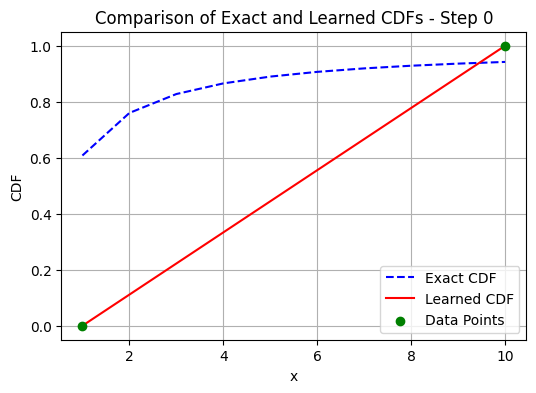

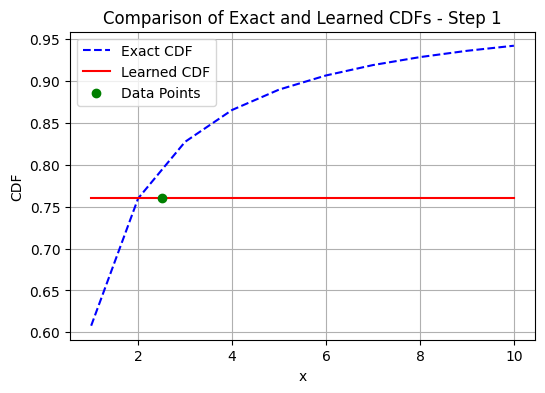

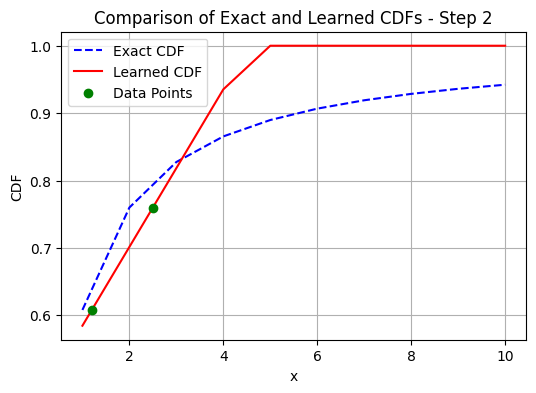

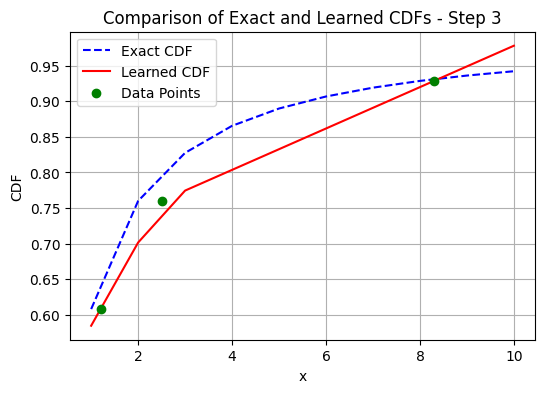

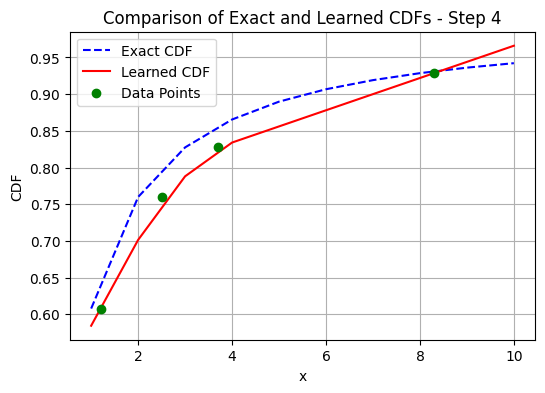

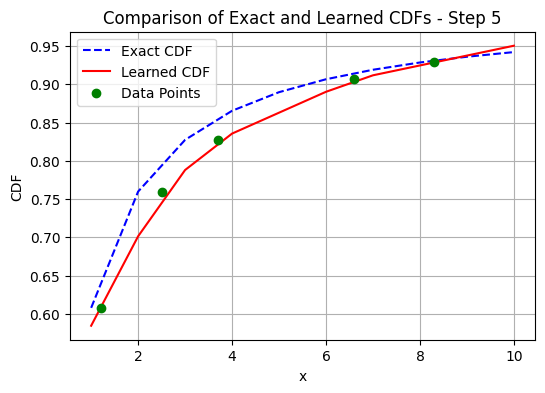

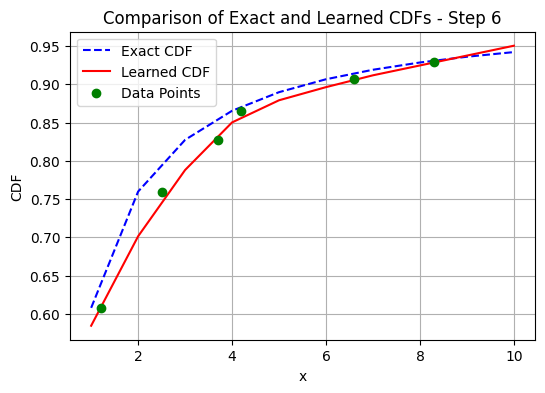

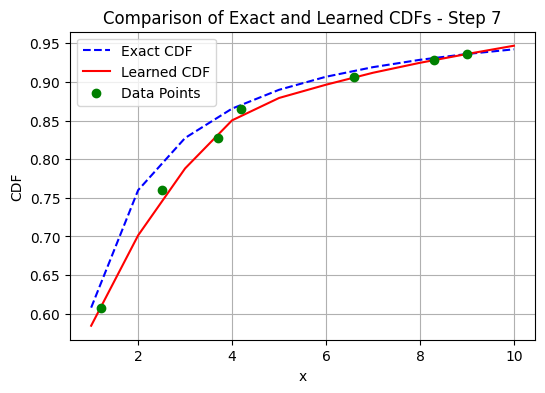

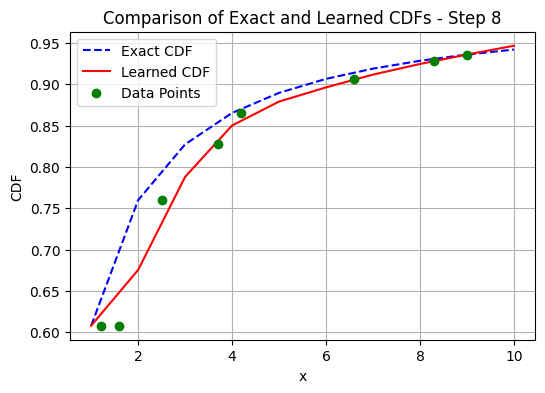

In [3]:
# Define the domain and Zipfian parameter
a, b = 1, 10  # Domain
s = 2  # Zipfian parameter


# Initialize isotonic regression model
iso_reg = IsotonicRegression(increasing=True)

# Generate test values over the domain
x_values = np.arange(a, b + 1)
exact_cdf_values = zipf.cdf(x_values, s)

# Initial uniform data
initial_points = np.array([a, b])
initial_cdf_values = np.array([0.0, 1.0])  # Uniform assumption

# Fit initial model
iso_reg.fit(initial_points, initial_cdf_values)

# Initial plot
learned_cdf_values = iso_reg.predict(x_values)
plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=0, noisy_data=(initial_points, initial_cdf_values))

# Incremental updates with noisy Zipfian data
additional_points = np.array([2.5, 1.2, 8.3, 3.7, 6.6, 4.2, 9.0, 1.6])
noise_level = 0.02  # Adjust noise level as needed

initial_points_removed = False

for step, new_point in enumerate(additional_points, start=1):
    new_cdf_value = generate_noisy_zipfian_cdf(new_point, s, noise_level)

    # Update the model with the new point
    all_points = np.append(iso_reg.X_thresholds_, new_point)
    all_cdf_values = np.append(iso_reg.y_thresholds_, new_cdf_value)
    
    # Remove initial points only once
    if not initial_points_removed and len(all_points) > 2:
        all_points = all_points[2:]
        all_cdf_values = all_cdf_values[2:]
        initial_points_removed = True
    
    iso_reg.fit(all_points, all_cdf_values)

    # Predict and plot
    #learned_cdf_values = iso_reg.predict(x_values)
    learned_cdf_values = predict_cdf_with_extrapolation(iso_reg, x_values)
    plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=step, noisy_data=(all_points, all_cdf_values))

#### Learning the CDF of numerical table attributes from selectivities of one-sided range predicates.

Will test on the `c_nationkey` attribute of the customer table.

In [4]:
# set up query generator
qg = TPCH_QGEN(DBNAME='tpch10_skew')

# Get the statistics for all tables in the tpch database
tables, pk_columns = get_tpch_schema()
table_names = list(tables.keys())
stats = {}
estimated_rows = {}
for table_name in table_names:
    stats[table_name], estimated_rows[table_name] = get_table_stats(table_name, dbname="tpch10")

table_attributes = {}
for table_name in table_names:
    table_attributes[table_name] = list(stats[table_name].keys())

# create a dictionary and specify whether each attribute in each table is numeric or char
data_type_dict = {}
for table_name in tables.keys():
    for column_name, column_type in tables[table_name]:
        if ("INT" in column_type) or ("DECIMAL" in column_type) or ("BIT" in column_type):
            data_type_dict[column_name] = "numeric"
        else:
            data_type_dict[column_name] = "char"   

In [5]:
# load actual stats from pickle file
with open('tpch10_skew_stats.pkl', 'rb') as f:
    actual_stats = pickle.load(f)

In [6]:
c_nationkey_stats = actual_stats['customer']['c_nationkey']
print(c_nationkey_stats)

{'min': 0, 'max': 24, 'total_count': 1500000, 'distinct_count': 25, 'histogram': {0: 47704, 1: 86742, 2: 53076, 3: 84877, 4: 70086, 5: 53448, 6: 44748, 7: 44405, 8: 61934, 9: 50617, 10: 57095, 11: 42172, 12: 51829, 13: 103247, 14: 36509, 15: 153124, 16: 46098, 17: 58485, 18: 61718, 19: 44427, 20: 56483, 21: 44522, 22: 51881, 23: 58816, 24: 35957}}


Implement a function for computing the exact selectivity of any one-sides range predicate, either `<=` or `>`

In [7]:
# function for computing selectivity of one-sided range predicates using actual stats
def exact_selectivity_onesided_range(actual_table_stats, column_name, predicate_type, boundary_value):
    # make sure attribute data type is numeric
    if data_type_dict[column_name] != "numeric":
        raise ValueError("Attribute data type must be numeric")
    
    stats = actual_table_stats[column_name]
    total_rows = stats['total_count']
    #num_distinct = stats['distinct_count']
    min_value = stats['min']
    max_value = stats['max']
    histogram = stats['histogram']

    # check if histogram is available
    if histogram:
        # find all values that fall within the range
        selectivity = 0
        for value, count in histogram.items():
                if value <= boundary_value:
                    selectivity += count 
                else:
                    break      
        
        if predicate_type == "<=":
            selectivity = selectivity / total_rows
        elif predicate_type == ">":
            selectivity = 1 - (selectivity / total_rows)    
        else:
            raise ValueError("Predicate type must be '<=' or '>'")

    else:
        # if histogram is not available, use min and max values
        s = (boundary_value - min_value) / (max_value - min_value)
        if predicate_type == "<=":
            selectivity = s
        elif predicate_type == ">":
            selectivity = 1 - s
        else:
            raise ValueError("Predicate type must be '<=' or '>'")

    return selectivity

Selectivity of c_nationkey > 1: 0.9103693333333334


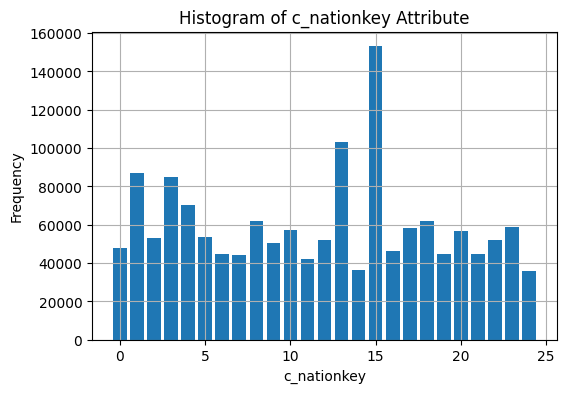

In [8]:
# test the selectivity computation function
table_name = "customer"
column_name = "c_nationkey"
table_stats = actual_stats['customer']
predicate_type = ">"
boundary_value = 1
selectivity = exact_selectivity_onesided_range(table_stats, column_name, predicate_type, boundary_value)

print(f"Selectivity of {column_name} {predicate_type} {boundary_value}: {selectivity}")

# plot the histogram of the c_nationkey attribute
plt.figure(figsize=(6, 4))
plt.bar(c_nationkey_stats['histogram'].keys(), c_nationkey_stats['histogram'].values())
plt.xlabel('c_nationkey')
plt.ylabel('Frequency')
plt.title('Histogram of c_nationkey Attribute')
plt.grid(True)
plt.show()


Fit an isotonic regression model on the `c_nationkey` attribute's distribution

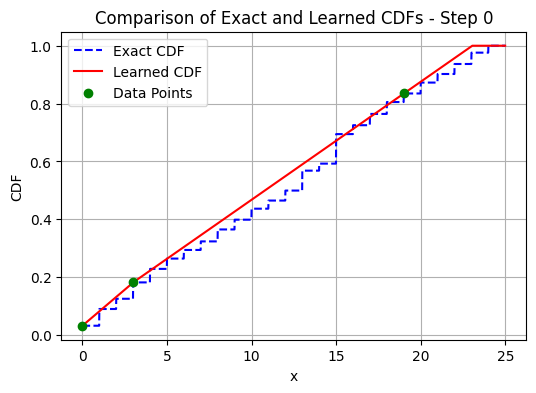

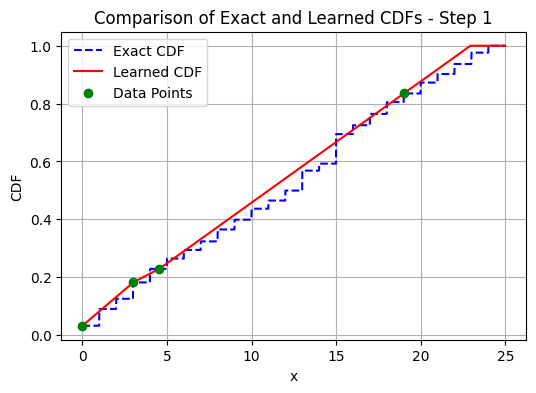

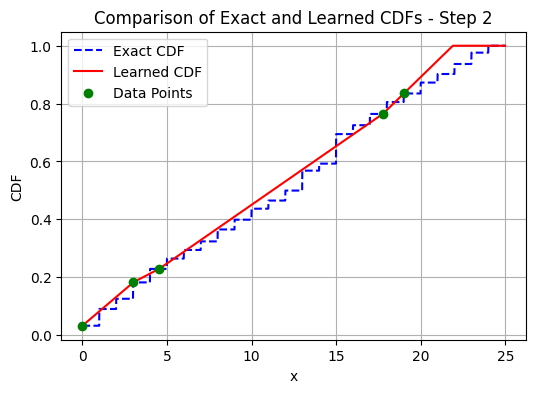

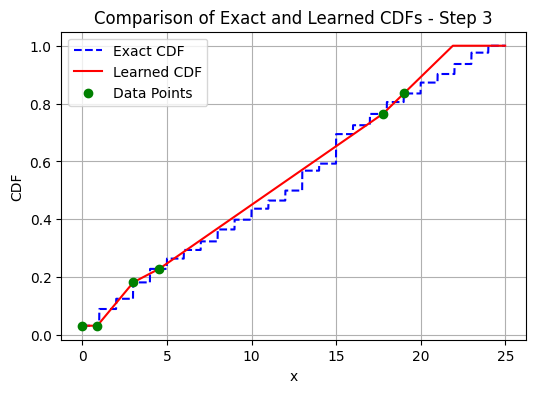

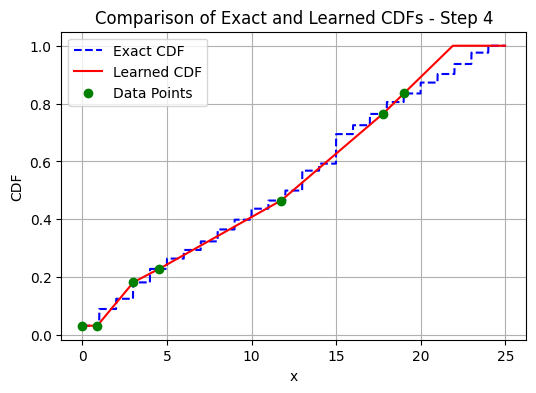

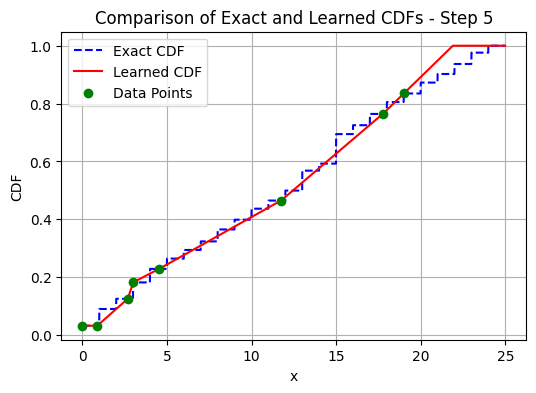

In [15]:
# Generate test values over the domain
x_values = np.arange(0, 25, 1)
exact_cdf_values = [exact_selectivity_onesided_range(table_stats, "c_nationkey", "<=", x) for x in x_values]

# Initialize isotonic regression model
iso_reg = IsotonicRegression(increasing=True)


# data for fitting the mode, sample a small fraction of the x_values
sampled_indices = np.random.choice(len(x_values), 3, replace=False)
initial_points = x_values[sampled_indices]
initial_cdf_values = [exact_selectivity_onesided_range(table_stats, "c_nationkey", "<=", x) for x in initial_points]

# Fit initial model
iso_reg.fit(initial_points, initial_cdf_values)

# Initial plot
x_values_plot = np.arange(0, 25, 0.01)
exact_cdf_values_plot = [exact_selectivity_onesided_range(table_stats, "c_nationkey", "<=", x) for x in x_values_plot]
learned_cdf_values_plot = predict_cdf_with_extrapolation(iso_reg, x_values_plot)
plot_cdf(x_values_plot, exact_cdf_values_plot, learned_cdf_values_plot, step=0, noisy_data=(initial_points, initial_cdf_values))


# now sample 5 new points and update the model
new_points = np.random.uniform(0, 24, 5)
cdf_values = [exact_selectivity_onesided_range(table_stats, "c_nationkey", "<=", x) for x in new_points]

# incrementally update the model
for step, (new_point, new_cdf_value) in enumerate(zip(new_points, cdf_values), start=1):
    update_model(iso_reg, new_point, new_cdf_value)
    learned_cdf_values_plot = predict_cdf_with_extrapolation(iso_reg, x_values_plot)
    plot_cdf(x_values_plot, exact_cdf_values_plot, learned_cdf_values_plot, step=step, noisy_data=(iso_reg.X_thresholds_, iso_reg.y_thresholds_))





Now, let's use the learned CDF to predict the selectivities, and compare with exact selectivity.

In [10]:
# function for predicting selectivity of one-sided range predicates using the learned model
def predict_selectivity_onesided_range(cdf_model, column_name, predicate_type, boundary_value):
    # make sure attribute data type is numeric
    if data_type_dict[column_name] != "numeric":
        raise ValueError("Attribute data type must be numeric")
    
    cdf_value = predict_cdf_with_extrapolation(cdf_model, [boundary_value])[0]
    if predicate_type == "<=":
        selectivity = cdf_value
    elif predicate_type == ">":
        selectivity = 1 - cdf_value
    else:
        raise ValueError("Predicate type must be '<=' or '>'")
    
    return selectivity

In [13]:
# test the selectivity prediction function, compare with actual stats

# get some test values for the c_nationkey attribute
test_values = np.random.uniform(0, 24, 5)

# compuet the actual selectivity
actual_selectivities = [exact_selectivity_onesided_range(table_stats, "c_nationkey", "<=", x) for x in test_values]

# predict the selectivity using the learned model
predicted_selectitivies = [predict_selectivity_onesided_range(iso_reg, "c_nationkey", "<=", x) for x in test_values]

# compare the actual and predicted selectivities
for test_value, actual_selectivity, predicted_selectivity in zip(test_values, actual_selectivities, predicted_selectitivies):
    print(f"Test Value: {test_value:.3f}, Actual Selectivity: {actual_selectivity:.3f}, Predicted Selectivity: {predicted_selectivity:.3f}, Absolute Error: {abs(actual_selectivity - predicted_selectivity):.3f}")



Test Value: 0.917, Actual Selectivity: 0.032, Predicted Selectivity: 0.038, Absolute Error: 0.006
Test Value: 22.083, Actual Selectivity: 0.937, Predicted Selectivity: 0.913, Absolute Error: 0.024
Test Value: 10.729, Actual Selectivity: 0.436, Predicted Selectivity: 0.450, Absolute Error: 0.013
Test Value: 16.181, Actual Selectivity: 0.725, Predicted Selectivity: 0.723, Absolute Error: 0.002
Test Value: 2.314, Actual Selectivity: 0.125, Predicted Selectivity: 0.124, Absolute Error: 0.001
